In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from __future__ import division

import contextlib
import os, platform, sys, traceback
from pprint import pformat, pprint
import numpy as np
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip
import random

from schlichtanders.mycontextmanagers import ignored
from schlichtanders.myplot import add_point
import matplotlib.pyplot as plt

inf = float("inf")

from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myobjects import NestedNamespace, Namespace

import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
from theano_models import data

from sklearn import cross_validation
from theano.tensor.shared_randomstreams import RandomStreams

from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float, Boolean
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from copy import copy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

EPS = 1e-8

pm.RNG = NestedNamespace(tm.PooledRandomStreams(pool_size=int(5e8)), RandomStreams())

__file__ = os.path.realpath('__file__')
if platform.system() == "Windows":
    from schlichtanders.myos import replace_unc
    __file__ = replace_unc(__file__)
__path__ = os.path.dirname(__file__)
__parent__ = os.path.dirname(__path__)

class Track(object):
    def __getattr__(self, item):
        return tm.track_model(getattr(tm, item))
track = Track()

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
datasetname = "boston"
Z, X = getattr(data, "_" + datasetname)()
# normalization is standard in Probabilistic Backpropagation Paper
X_mean = X.mean(0)
X_std = X.std(0)
X = (X - X_mean) / X_std
Z_mean = Z.mean(0)
Z_std = Z.std(0)
Z = (Z - Z_mean) / Z_std

X, TX, Z, TZ = cross_validation.train_test_split(X, Z, test_size=0.1) # 10% test used in paper
X, VX, Z, VZ = cross_validation.train_test_split(X, Z, test_size=0.1) # 20% validation used in paper

In [4]:
engine = create_engine('sqlite:///' + os.path.join(__path__, 'test_planarflow.db'))
Base = declarative_base(bind=engine)

In [5]:
class RandomHyper(Base):
    __tablename__ = "hyper"
    id = Column(Integer, primary_key=True)

    # hyper parameters:
    datasetname = Column(String)
    max_epochs_without_improvement = Column(Integer)
    average_n = Column(Integer)
    units_per_layer = Column(Integer)
    minus_log_s = Column(Integer)
    batch_size = Column(Integer)
    
    n_normflows = Column(Integer)
    
    opt_identifier = Column(String)
    opt_momentum = Column(Float)
    opt_offset = Column(Float)
    opt_decay = Column(Float)
    opt_step_rate = Column(Float)

    # baseline:
    baseline_best_val_loss = Column(Float)
    baseline_best_parameters = Column(PickleType, nullable=True)
    baseline_train_loss = Column(PickleType)
    baseline_val_loss = Column(PickleType)
    baseline_epochs = Column(Integer)
    baseline_init_params = Column(PickleType, nullable=True)
    baseline_val_error_rate = Column(Float)

    # planarflow:
    planarflow_best_val_loss = Column(Float)
    planarflow_best_parameters = Column(PickleType, nullable=True)
    planarflow_train_loss = Column(PickleType)
    planarflow_val_loss = Column(PickleType)
    planarflow_epochs = Column(Integer)
    planarflow_init_params = Column(PickleType, nullable=True)
    planarflow_val_error_rate = Column(Float)

    # planarflow deterministic:
    planarflowdet_best_val_loss = Column(Float)
    planarflowdet_best_parameters = Column(PickleType, nullable=True)
    planarflowdet_train_loss = Column(PickleType)
    planarflowdet_val_loss = Column(PickleType)
    planarflowdet_epochs = Column(Integer)
    planarflowdet_init_params = Column(PickleType, nullable=True)
    planarflowdet_val_error_rate = Column(Float)

    # planarflow maximum likelihood:
    planarflowml_best_val_loss = Column(Float)
    planarflowml_best_parameters = Column(PickleType, nullable=True)
    planarflowml_train_loss = Column(PickleType)
    planarflowml_val_loss = Column(PickleType)
    planarflowml_epochs = Column(Integer)
    planarflowml_init_params = Column(PickleType, nullable=True)
    planarflowml_val_error_rate = Column(Float)

    def __init__(self, hyper_dict=None):
        # we directly refer to dict as sqlalchemy deletes the dict once committed (probably for detecting changes
        if hyper_dict is not None:
            for k, v in hyper_dict.iteritems():
                if not k.startswith("_"):
                    setattr(self, k, copy(v))
            self.init_results()
            return
        self.datasetname = datasetname
        # hyper parameters:
        self.max_epochs_without_improvement = 30
        self.batch_size = 10  # random.choice([1,10, 100])
        self.average_n = 1
        self.units_per_layer = 50
        self.minus_log_s = random.choice([1,2,3,4,5,6,7])
        # the prior is learned together with the other models in analogy to the paper Probabilistic Backpropagation
        
        self.n_normflows = 1  # random.choice([1,2,3,4,8,20])  #32 is to much for theano... unfortunately
        
        self.opt_identifier = random.choice(["adadelta", "adam", "rmsprop"])
        if self.opt_identifier == "adadelta":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.9, 1)])
            self.opt_offset = random.choice([5e-5, 1e-8])
            self.opt_step_rate = random.choice([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
        elif self.opt_identifier == "adam":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.8, 0.93)])
            self.opt_offset = 10 ** -np.random.uniform(3, 4)
            self.opt_step_rate = random.choice([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
        elif self.opt_identifier == "rmsprop":
            self.opt_momentum = random.choice([np.random.uniform(0.002, 0.008), np.random.uniform(0.9, 1)])
            self.opt_offset = np.random.uniform(0, 0.000045)
            self.opt_step_rate = random.choice([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
        self.opt_decay = np.random.uniform(0.78, 1)
        
        self.init_results()
    
    def init_results(self):
        # extra for being able to reset results for loaded hyperparameters
        for prefix in ['baseline_',
                       'planarflow_', 'planarflowdet_', 'planarflowml_']:
            setattr(self, prefix + "best_parameters", None)
            setattr(self, prefix + "best_val_loss", inf)
            setattr(self, prefix + "train_loss", [])
            setattr(self, prefix + "val_loss", [])
            setattr(self, prefix + "best_epoch", 0)
            setattr(self, prefix + "init_params ", None)
            setattr(self, prefix + "val_error_rate", inf)

Base.metadata.create_all()
Session = sessionmaker(bind=engine)
sql_session = Session()

In [6]:
Reparam = tm.as_proxmodel('parameters')(tm.prox_reparameterize)
Flat = tm.as_proxmodel("to_be_randomized")(tm.prox_flatten)

In [7]:
hyper = RandomHyper()
hyper_dict = copy(hyper.__dict__)
pprint(hyper_dict)
sql_session.add(hyper)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f737515ac90>,
 'average_n': 1,
 'baseline_best_epoch': 0,
 'baseline_best_parameters': None,
 'baseline_best_val_loss': inf,
 'baseline_init_params ': None,
 'baseline_train_loss': [],
 'baseline_val_error_rate': inf,
 'baseline_val_loss': [],
 'batch_size': 10,
 'datasetname': 'boston',
 'max_epochs_without_improvement': 30,
 'minus_log_s': 1,
 'n_normflows': 1,
 'opt_decay': 0.9102151242348973,
 'opt_identifier': 'adam',
 'opt_momentum': 0.0027284018650880447,
 'opt_offset': 0.0005238597540616855,
 'opt_step_rate': 0.1,
 'planarflow_best_epoch': 0,
 'planarflow_best_parameters': None,
 'planarflow_best_val_loss': inf,
 'planarflow_init_params ': None,
 'planarflow_train_loss': [],
 'planarflow_val_error_rate': inf,
 'planarflow_val_loss': [],
 'planarflowdet_best_epoch': 0,
 'planarflowdet_best_parameters': None,
 'planarflowdet_best_val_loss': inf,
 'planarflowdet_init_params ': None,
 'planarflowdet_train_loss'

In [8]:
track.squareplus

<function theano_models.base_tools.squareplus>

In [9]:
# this is extremely useful to tell everything the default sizes
input = tm.as_tensor_variable(X[0], name="X")

predictor = dm.Mlp(
    input=input,
    output_size=Z.shape[1],
    output_transfer='identity',
    hidden_sizes=[hyper.units_per_layer]*1,
    hidden_transfers=["rectifier"]*1
)
target_distribution = pm.DiagGaussianNoise(predictor)
targets = tm.Merge(target_distribution, predictor, Flat(predictor['parameters']))

_total_size = tm.total_size(targets['to_be_randomized'])
params_base = pm.DiagGauss(output_size=_total_size)
normflows = [dm.PlanarTransform() for _ in range(hyper.n_normflows)]
# LocScaleTransform for better working with PlanarTransforms
params = params_base
for transform in normflows:
    params = tm.normalizing_flow(transform, params)  # returns transform, however with adapted logP

prior = tm.fix_params(pm.Gauss(output_shape=(_total_size,), init_var=np.exp(-2* hyper.minus_log_s)))
model = tm.variational_bayes(targets, 'to_be_randomized', params, priors=prior)
loss = tm.loss_variational(model)

# all_params = tm.prox_reparameterize(model['parameters_positive'], track.softplus, track.softplus_inv)
all_params = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
all_params += model['parameters']
flat = tm.prox_flatten(tm.prox_center(all_params))
parameters = flat

In [10]:
prefix = "planarflow"
if prefix and not prefix.endswith("_"):  # source of bugs
    prefix += "_"
tm.reduce_all_identities()

n_batches = X.shape[0] // hyper.batch_size  # after this many steps we went through the whole data set once
climin_args = izip(izip(chunk(hyper.batch_size, cycle(Z)), chunk(hyper.batch_size, cycle(X))), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)

assert len(list(weights_regularizer_1epoch())) == n_batches

optimizer_kwargs = tm.numericalize(loss, parameters,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.size, scale=0.5),  # better more initial randomness
#     profile=True,
    mode='FAST_COMPILE' if hyper.n_normflows > 10 else 'FAST_RUN',  
                                   # error that theano cannot handle ufuncs with more than 32 arguments
    batch_common_rng=False
)

opt = optimizer(
    identifier=hyper.opt_identifier,
    step_rate=hyper.opt_step_rate,
    momentum=hyper.opt_momentum,
    decay=hyper.opt_decay,
    offset=hyper.opt_offset,
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

# start values:
setattr(hyper, prefix + "init_params", copy(opt.wrt))
setattr(hyper, prefix + "best_val_loss",
        optimizer_kwargs['num_loss'](opt.wrt, VZ, VX, no_annealing=True))

batch_precompile
batch_precompile


/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adam.Adam'>
  % (i, klass))


In [11]:
optimizer_kwargs['num_loss'](opt.wrt, VZ, VX, no_annealing=True)

19990.013571234689

In [12]:
optimizer_kwargs['num_jacobian'](opt.wrt, VZ, VX, no_annealing=True)

array([-36336.47363202,     45.97763668,    837.02098762, ...,
         -307.21401231,   -735.95429586,   -625.91815921])

<IPython.core.display.Javascript object>


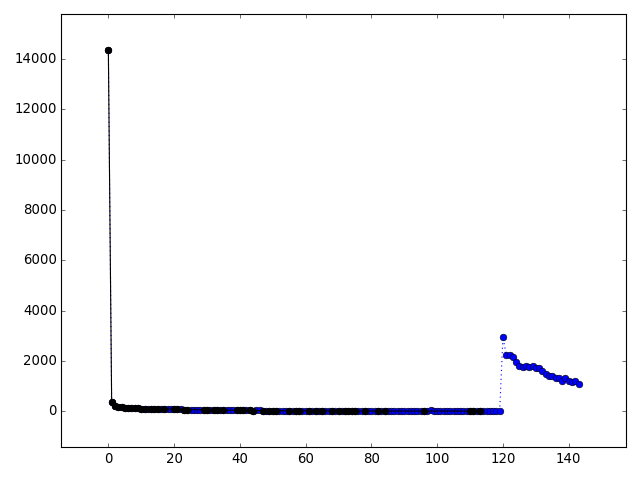

In [13]:
plt.figure()
current_epoch = opt.n_iter//n_batches
h_curr = plt.plot(current_epoch, getattr(hyper, prefix + 'best_val_loss'), "bo:", label="best val loss")[0]
h_best = plt.plot(current_epoch, getattr(hyper, prefix + 'best_val_loss'), "ko-", label="curr val loss")[0]

In [14]:
# val_losses = getattr(hyper, prefix + "val_loss")
# train_losses = getattr(hyper, prefix + "train_loss")
for info in every(n_batches, opt):
    current_epoch = info['n_iter']//n_batches
    if current_epoch - getattr(hyper, prefix + "best_epoch") > hyper.max_epochs_without_improvement:
        break
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ, VX, no_annealing=True)
    if val_loss < getattr(hyper, prefix + "best_val_loss") - EPS:
        setattr(hyper, prefix + "best_epoch", current_epoch)
        setattr(hyper, prefix + "best_parameters", copy(opt.wrt))  
        # copy is needed as climin works inplace on array
        setattr(hyper, prefix + "best_val_loss", val_loss)
        add_point(h_best, current_epoch, val_loss)
    add_point(h_curr, current_epoch, val_loss)
    # val_losses.append(val_loss)

    # visualize training loss for comparison:
    # training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z[:10], X[:10], no_annealing=True)
    # train_losses.append(training_loss)

# TODO add accuracy / error rate
sql_session.commit()  # this updates all set information within sqlite database

In [18]:
optimizer_kwargs['num_loss'](getattr(hyper, prefix + "best_parameters"), VZ, VX, no_annealing=True)

8.4623824919174666

In [19]:
optimizer_kwargs['num_jacobian'](getattr(hyper, prefix + "best_parameters"), VZ, VX, no_annealing=True)

array([ 0.33723336, -0.21448044,  0.12888121, ...,  0.23120741,
       -0.0159679 , -0.07941732])